In [ ]:
# default_exp analyses

# Recall Probability by Spacing
> "The beneficial mnemonic effects of spaced over massed learning is one of the most widely documented and well studied memory phenomena. Although it is seen in a wide range of tasks, the spacing effect is particularly strong in free recall, where the probability of recalling a repeated word often increases monotonically to spacings of 20 or more items (Cepeda, Pashler, Vul, Wixted, & Rohrer, 2006; Delaney, Verkoeijen, & Spirgel, 2010; Donovan & Radosevich, 1999; Madigan, 1969; Melton, 1970)." - Lohnas & Kahana, 2014

## Data Preparation

In [1]:
from compmemlearn.datasets import prepare_lohnas2014_data

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,condition,first_input
0,1,1,0,1,1.0,True,True,0,False,4,1
1,1,1,1,2,2.0,True,True,0,False,4,2
2,1,1,2,3,3.0,True,True,0,False,4,3
3,1,1,3,4,4.0,True,True,0,False,4,4
4,1,1,4,5,5.0,True,True,0,False,4,5


## Analysis
We optimize this with numba (and some creative Python) to speed up the calculation.

### Fast Array Generation
`DataFrame`s contain granular subject-by-subject information and are easier to plot using the `seaborn` library. 
But sometimes we don't need this granular information and mainly want to perform our analysis as quickly as possible -- perhaps to help with model fitting or analysis. 
In that case, representing results with `numpy` arrays and performing just-in-time compilation of our function using `numba` might be preferred. 
We include `analyses.fast_rpl` in our library for that purpose here.

The function assumes items are repeated up to 2 times.

In [2]:
# export

from numba import njit, prange
import numpy as np

@njit(nogil=True, parallel=True)
def fast_rpl(study_positions_in_recall_order, presentations, max_lag=8):
    
    assert(len(presentations) == len(study_positions_in_recall_order))

    total_presented, total_retrieved = np.zeros(max_lag+2), np.zeros(max_lag+2)

    for trial_index in prange(len(presentations)):
        presented, retrieved = np.zeros(max_lag+2), np.zeros(max_lag+2)
        trial = study_positions_in_recall_order[trial_index]
        trial = trial[trial > 0]-1
        
        for item in np.unique(presentations[trial_index]):
            for idx, val in np.ndenumerate(presentations[trial_index]):
                if val == item:
                    locationA = idx[0]
                    break

            lag = 0
            if locationA < len(presentations[trial_index]):
                for idx, val in np.ndenumerate(presentations[trial_index][locationA+1:]):
                    if val == item:
                        lag = 1 + idx[0]
                        break

            presented[lag] += 1
            retrieved[lag] += locationA in trial
            
        total_presented += presented
        total_retrieved += retrieved

    return total_retrieved/total_presented

In [28]:
# export

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from compmemlearn.datasets import events_metadata, generate_trial_mask


def plot_rpl(data, trial_query, contrast_name='', labels=None, axis=None):

    lags = ['N/A', '0', '1-2', '3-5', '6-8']

    if axis is None:
        plt.figure()
        axis = plt.gca()

    if labels is None:
        labels = [''] * len(data)

    result = []
    for data_index, events in enumerate(data):

        # generate and subset trials array and list of list_lengths based on trial_query
        trials, list_lengths, presentations = events_metadata(events)
        trial_mask = generate_trial_mask(events, trial_query)
        chose = [i for i in range(len(trial_mask)) if np.sum(trial_mask[i]) != 0]
        assert(len(chose) == 1)
        chose = chose[0]
        trials = trials[chose]
        presentations = presentations[chose]
        trial_mask = trial_mask[chose]

        for subject in pd.unique(events.subject):
            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f"subject == {subject}")[chose], trial_mask
            )

            if np.sum(subject_specific_trial_mask) == 0:
                continue

            subject_result = fast_rpl(trials[subject_specific_trial_mask], presentations[subject_specific_trial_mask])
            binned = np.zeros(5)
            binned[0] = subject_result[0]
            binned[1] = subject_result[1]
            binned[2] = (subject_result[2] + subject_result[3])/2
            binned[3] = (subject_result[4] + subject_result[5] + subject_result[6])/3
            binned[4] = (subject_result[7] + subject_result[8] + subject_result[9])/3

            result.append(pd.DataFrame.from_dict(
                {
                    "subject": subject,
                    "lag": lags,
                    "recall": binned,
                    contrast_name: labels[data_index],
                }
            ))

    result = pd.concat(result)
    
    if contrast_name:
        sns.pointplot(ax=axis, data=result, x='lag', y='recall',  join=False, hue=contrast_name)
        axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else: 
        sns.pointplot(ax=axis, data=result, x='lag', y='recall',  join=False)
    axis.set(xlabel='Study Position', ylabel='Recall Rate')

    return axis

In [23]:
condition = 4

result = fast_rpl(
    trials[list_types>=condition], presentations[list_types>=condition], max_lag=8)

# lohnas 2014 bins result by N/A, 0, 1-2, 3-5, and 6-8 number of intervening items
binned = np.zeros(5)
binned[0] = result[0]
binned[1] = result[1]
binned[2] = (result[2] + result[3])/2
binned[3] = (result[4] + result[5] + result[6])/3
binned[4] = (result[7] + result[8] + result[9])/3
print(binned)

[0.37278912 0.43928571 0.47678571 0.55714286 0.57857143]


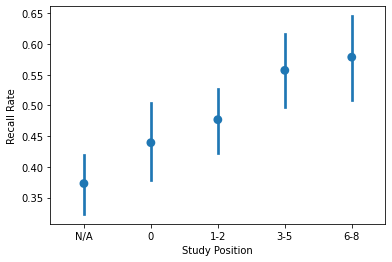

In [29]:
import matplotlib.pyplot as plt

plt.figure()
axis = plt.gca()
plot_rpl([events], 'condition == 4', axis=axis);

In [ ]:
%%timeit
fast_rpl(presentations, trials, max_lag=8)

2.74 ms ± 253 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### DataFrame
The `psifr` library doesn't have a function to generate `pandas` DataFrames containing conditional stop probability information, so we make our own. For efficiency, it mainly consists of calls to `fast_rpl`. Since we normally compare our analyses with the results from Lohnas & Kahana (2014), we'll automatically bin results between `['N/A', '0', '1-2', '3-5', '6-8']` even though `fast_rpl` provides more granular information.

In [ ]:
# export

import pandas as pd

def rpl(presentations, trials, subjects, trial_count, list_length, max_lag=8):
    #subjects = len(np.unique(events.subject))
    #trial_count = np.max(events.list)
    #list_length = np.max(events.input)
    #lags = ['N/A'] + list(range(max_lag+1))
    lags = ['N/A', '0', '1-2', '3-5', '6-8']
    
    result = {'subject': [], 'lag': [], 'prob': []}
    
    for subject in range(subjects):

        subject_result = fast_rpl(
            trials[subject*trial_count:(subject+1)*trial_count], presentations[subject*trial_count:(subject+1)*trial_count], max_lag)
        
        binned = np.zeros(5)
        binned[0] = subject_result[0]
        binned[1] = subject_result[1]
        binned[2] = (subject_result[2] + subject_result[3])/2
        binned[3] = (subject_result[4] + subject_result[5] + subject_result[6])/3
        binned[4] = (subject_result[7] + subject_result[8] + subject_result[9])/3

        result['subject'] += [subject+1]*len(lags)
        result['lag'] += lags
        result['prob'] += binned.tolist()
        
    return pd.DataFrame(result)

## Plotting Demo

Text(0, 0.5, 'Recall Probability')

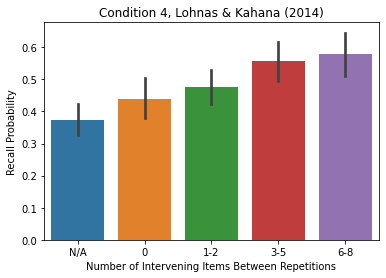

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

condition = 4
source = 'Lohnas & Kahana (2014)'

subject_count = len(np.unique(events.subject))
trial_count = int(np.max(events.list)/4)

data = rpl(
    presentations[list_types>=4], trials[list_types>=4], 
    subject_count, trial_count, list_length)

sns.barplot(data=data, x='lag', y='prob')

plt.title('Condition {}, {}'.format(condition, source))
plt.xlabel('Number of Intervening Items Between Repetitions')
plt.ylabel('Recall Probability')